# Black Friday Sales - Analysis and Prediction

### Data loading, pre-processing and cleaning

In [12]:
# Import the necessary modules
from pyspark.sql import SQLContext, Row
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("BlackFriday")
sc = SparkContext.getOrCreate(conf = conf)

In [13]:
# Load in the data
rdd = sc.textFile('BlackFriday.csv')

In [14]:
# Split lines on commas
rdd = rdd.map(lambda line: line.split(","))

# Inspect the first 2 lines 
rdd.take(2)

[[u'User_ID',
  u'Product_ID',
  u'Gender',
  u'Age',
  u'Occupation',
  u'City_Category',
  u'Stay_In_Current_City_Years',
  u'Marital_Status',
  u'Product_Category_1',
  u'Product_Category_2',
  u'Product_Category_3',
  u'Purchase'],
 [u'1000001',
  u'P00069042',
  u'F',
  u'0-17',
  u'10',
  u'A',
  u'2',
  u'0',
  u'3',
  u'',
  u'',
  u'8370']]

In [15]:
# Remove the header row from the data
header = rdd.first()
rdd = rdd.filter(lambda line: line != header)
rdd.take(2)

[[u'1000001',
  u'P00069042',
  u'F',
  u'0-17',
  u'10',
  u'A',
  u'2',
  u'0',
  u'3',
  u'',
  u'',
  u'8370'],
 [u'1000001',
  u'P00248942',
  u'F',
  u'0-17',
  u'10',
  u'A',
  u'2',
  u'0',
  u'1',
  u'6',
  u'14',
  u'15200']]

In [16]:
# Import the necessary modules 
from pyspark.sql import Row

# Map the RDD to a DF
df = rdd.map(lambda r1: Row(user_id=int(r1[0]),
                              product_id=r1[1],
                              gender=r1[2],
                              age=r1[3],
                              occupation=int(r1[4]),
                              city_category=r1[5],
                              stay_in_current_city_years=r1[6],
                              marital_status=int(r1[7]),
                              product_category_1=int(r1[8]),
                              product_category_2=r1[9],
                              product_category_3=r1[10],
                              purchase=int(r1[11]))).toDF()

# Show the top 2 rows 
df.show(2)

+----+-------------+------+--------------+----------+------------------+------------------+------------------+----------+--------+--------------------------+-------+
| age|city_category|gender|marital_status|occupation|product_category_1|product_category_2|product_category_3|product_id|purchase|stay_in_current_city_years|user_id|
+----+-------------+------+--------------+----------+------------------+------------------+------------------+----------+--------+--------------------------+-------+
|0-17|            A|     F|             0|        10|                 3|                  |                  | P00069042|    8370|                         2|1000001|
|0-17|            A|     F|             0|        10|                 1|                 6|                14| P00248942|   15200|                         2|1000001|
+----+-------------+------+--------------+----------+------------------+------------------+------------------+----------+--------+--------------------------+-------+
only

In [17]:
# View it a better table format using pandas
df.toPandas().head()

,age,city_category,gender,marital_status,occupation,product_category_1,product_category_2,product_category_3,product_id,purchase,stay_in_current_city_years,user_id
0,0-17,A,F,0,10,3,,,P00069042,8370,2,1000001
1,0-17,A,F,0,10,1,6,14,P00248942,15200,2,1000001
2,0-17,A,F,0,10,12,,,P00087842,1422,2,1000001
3,0-17,A,F,0,10,12,14,,P00085442,1057,2,1000001
4,55+,C,M,0,16,8,,,P00285442,7969,4+,1000002


###### Looks like product category 2 and 3 have missing values. Lets check the dataframe schema.

In [18]:
# Print the schema of `df` 
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- city_category: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- marital_status: long (nullable = true)
 |-- occupation: long (nullable = true)
 |-- product_category_1: long (nullable = true)
 |-- product_category_2: string (nullable = true)
 |-- product_category_3: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- purchase: long (nullable = true)
 |-- stay_in_current_city_years: string (nullable = true)
 |-- user_id: long (nullable = true)



In [19]:
# Casting data type of product category 2 and 3 from string to float
from pyspark.sql.types import *

df = df.withColumn("product_category_2", df["product_category_2"].cast(FloatType())).withColumn("product_category_3", df["product_category_3"].cast(FloatType()))

In [20]:
# Print the schema of `df`
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- city_category: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- marital_status: long (nullable = true)
 |-- occupation: long (nullable = true)
 |-- product_category_1: long (nullable = true)
 |-- product_category_2: float (nullable = true)
 |-- product_category_3: float (nullable = true)
 |-- product_id: string (nullable = true)
 |-- purchase: long (nullable = true)
 |-- stay_in_current_city_years: string (nullable = true)
 |-- user_id: long (nullable = true)



In [21]:
# Viewing it a better table format
df.toPandas().head()

,age,city_category,gender,marital_status,occupation,product_category_1,product_category_2,product_category_3,product_id,purchase,stay_in_current_city_years,user_id
0,0-17,A,F,0,10,3,NaN,NaN,P00069042,8370,2,1000001
1,0-17,A,F,0,10,1,6.0,14.0,P00248942,15200,2,1000001
2,0-17,A,F,0,10,12,NaN,NaN,P00087842,1422,2,1000001
3,0-17,A,F,0,10,12,14.0,NaN,P00085442,1057,2,1000001
4,55+,C,M,0,16,8,NaN,NaN,P00285442,7969,4+,1000002


In [22]:
# Identifying the null values in the data
# https://stackoverflow.com/questions/44413132/count-the-number-of-missing-values-in-a-dataframe-spark

from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).toPandas()

,age,city_category,gender,marital_status,occupation,product_category_1,product_category_2,product_category_3,product_id,purchase,stay_in_current_city_years,user_id
0,0,0,0,0,0,0,166986,373299,0,0,0,0


In [23]:
# Get all the unique values in product category 2
df.select("product_category_2").distinct().sort("product_category_2",ascending=False).show()

+------------------+
|product_category_2|
+------------------+
|              18.0|
|              17.0|
|              16.0|
|              15.0|
|              14.0|
|              13.0|
|              12.0|
|              11.0|
|              10.0|
|               9.0|
|               8.0|
|               7.0|
|               6.0|
|               5.0|
|               4.0|
|               3.0|
|               2.0|
|              null|
+------------------+



In [24]:
# Get all the unique values in product category 3
df.select("product_category_3").distinct().sort("product_category_3",ascending=False).show()

+------------------+
|product_category_3|
+------------------+
|              18.0|
|              17.0|
|              16.0|
|              15.0|
|              14.0|
|              13.0|
|              12.0|
|              11.0|
|              10.0|
|               9.0|
|               8.0|
|               6.0|
|               5.0|
|               4.0|
|               3.0|
|              null|
+------------------+



###### Product category 2 have unique values ranging from 2.0 to 18.0. Product category 3 have unique values ranging from 3.0 to 18.0. Therefore, We can assign 0 for the null values in both the columns.

In [25]:
# Get rid of the null values in all the columns and replace it by 0
for x in df.columns:
    df = df.na.fill(0,[x])

In [26]:
# Identifying the null values in the data again
from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).toPandas()

,age,city_category,gender,marital_status,occupation,product_category_1,product_category_2,product_category_3,product_id,purchase,stay_in_current_city_years,user_id
0,0,0,0,0,0,0,0,0,0,0,0,0


###### The data is now clean for analysis and visualization.

### Data Analysis and Visualization

In [27]:
# Importing libraries to visualize the data
import matplotlib.pyplot as plt
import seaborn as sns
df2=df.toPandas()
df.registerTempTable('bFridayTable')

In [28]:
# Total entries in the dataset
df.count()

537577

In [29]:
# Distinct values for each column
for i in df.columns:
    print(i, df.select(i).distinct().count())

('age', 7)
('city_category', 3)
('gender', 2)
('marital_status', 2)
('occupation', 21)
('product_category_1', 18)
('product_category_2', 18)
('product_category_3', 16)
('product_id', 3623)
('purchase', 17959)
('stay_in_current_city_years', 5)
('user_id', 5891)


###### From the above data, we come to know that during the black friday sale

    Total 3623 products were for sale
    Total 5891 shoppers participated in the sale

In [30]:
# Min and Max Purchase
df.select('purchase').describe().toPandas()

,summary,purchase
0,count,537577
1,mean,9333.859852635065
2,stddev,4981.022132656451
3,min,185
4,max,23961


- Min purchase: 185
- Max purchase: 23961

##### Age group distribution

+-----+------+
|  age| count|
+-----+------+
| 0-17| 14707|
|18-25| 97634|
|26-35|214690|
|36-45|107499|
|46-50| 44526|
|51-55| 37618|
|  55+| 20903|
+-----+------+



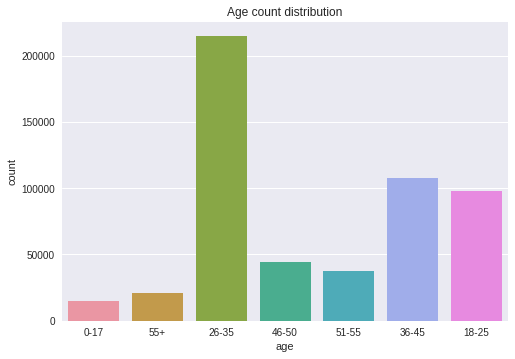

In [31]:
# Count distribution
df.groupBy("age").count().sort("age",ascending=True).show()
sns.countplot(df2.age).set_title("Age count distribution")
plt.show()

It's quite apparent that the largest age group amongst the customers is 26-35. 

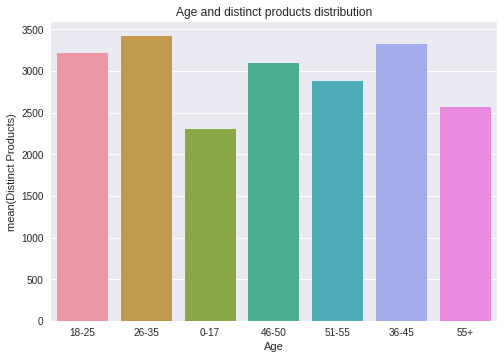

In [32]:
# Distinct product distribution
a_df = sqlContext.sql('select age, count( distinct product_id) as product_count from bFridayTable group by age').toPandas()
a_df.columns=['Age','Distinct Products']
sns.barplot(x='Age', y='Distinct Products', data=a_df).set_title("Age and distinct products distribution")
plt.show()

Interestingly, the distribution of product purchase, in terms of quantity, does not vary greatly amongst the age groups. This means that, though the 26-35 age group is the most popular, the other age groups purchase almost as many unique items as them. But does this mean that the amount of money spent amongst the age groups is the same? Let's see...

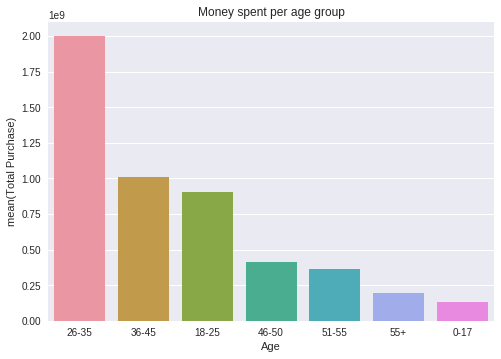

In [33]:
# Total money spent distribution
a_df=df.groupBy('age').sum('purchase').orderBy('sum(purchase)', ascending=False).toPandas()
a_df.columns=['Age','Total Purchase']
sns.barplot(x='Age', y='Total Purchase', data=a_df).set_title("Money spent per age group")
plt.show()

The chart clearly shows that the amount of money made from each age group correlates proportionally with the amount of customers within the age groups. This can be valuable information for the store, as it might want to add more products geared towards this age group in the future, or perhaps work on marketing different items to increase a broader diversity in the age groups of their customers.

##### Gender group distribution


+------+------+
|gender| count|
+------+------+
|     F|132197|
|     M|405380|
+------+------+



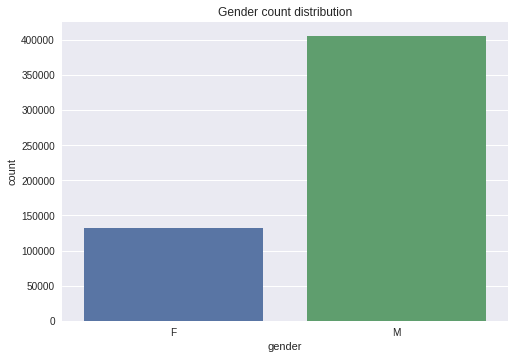

In [34]:
df.groupBy("gender").count().show()
sns.countplot(df2.gender).set_title("Gender count distribution")
plt.show()

The number of male shoppers exceeds the number of female shoppers by almost 4 times. Let's check the variety of products they shop for. Are female shoppers restricting themeselves to certain range of products?

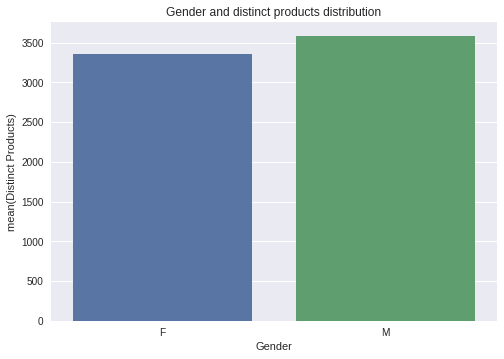

In [35]:
# Distinct product distribution
g_df = sqlContext.sql('select gender, count( distinct product_id) as product_count from bFridayTable group by gender').toPandas()
g_df.columns=['Gender','Distinct Products']
sns.barplot(x='Gender', y='Distinct Products', data=g_df).set_title("Gender and distinct products distribution")
plt.show()

We don't find a significant difference in the range of products.
Let's check average purchase amount for each group.

In [36]:
# Average Purchase
gender_purchase=df.groupBy('gender').avg('purchase').orderBy('avg(purchase)', ascending=False).toPandas()
gender_purchase.columns=['Gender','Average Purchase']
gender_purchase

,Gender,Average Purchase
0,M,9504.771713
1,F,8809.761349


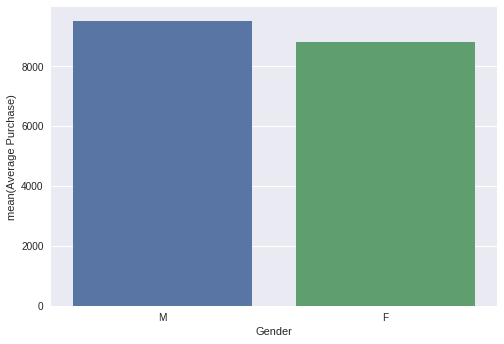

In [37]:
# Plotting the above results on graph
sns.barplot(x='Gender', y='Average Purchase', data=gender_purchase)
plt.show()

Again, we don't see a major difference in average purchase for male and female shoppers. Let's now demonstrate the different tendencies of male and female shoppers for product category 1.

In [38]:
# From our previous results we know that total femal shoppers = 132197 and total male shoppers = 405380
# https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/
prod1_gender = df.crosstab('product_category_1', 'gender')
prod1_gender = prod1_gender.withColumn('f_ratio', prod1_gender.F / 132197)
prod1_gender = prod1_gender.withColumn('m_ratio', prod1_gender.M / 405380)
prod1_gender = prod1_gender.withColumn('M/F', prod1_gender.m_ratio / prod1_gender.f_ratio)
prod1_gender = prod1_gender.withColumn('F/M', prod1_gender.f_ratio / prod1_gender.m_ratio)
prod1_gender.toPandas()

,product_category_1_gender,F,M,f_ratio,m_ratio,M/F,F/M
0,5,41199,107393,0.311649,0.264919,0.850058,1.176390
1,10,1138,3894,0.008608,0.009606,1.115868,0.896163
2,14,613,887,0.004637,0.002188,0.471870,2.119227
3,1,24401,113952,0.184581,0.281099,1.522908,0.656639
4,6,4475,15689,0.033851,0.038702,1.143303,0.874658
5,9,70,334,0.000530,0.000824,1.555993,0.642676
6,13,1428,4012,0.010802,0.009897,0.916204,1.091460
7,2,5573,17926,0.042157,0.044220,1.048947,0.953337
8,17,61,506,0.000461,0.001248,2.705079,0.369675
9,12,1497,2378,0.011324,0.005866,0.518023,1.930415


This table tells us a lot about how likely a type of product is to be bought in regards of gender. For instance, men are almost 1.1 times as likely to buy an item in category 10, while women are almost 1.17 times as likely to buy a product in category 5.

##### To get a better understanding, we will now analyse the purchase habits across the different city categories.

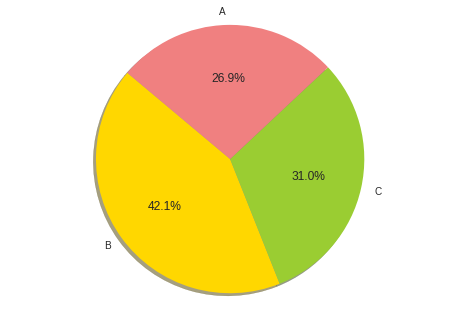

In [39]:
# https://pythonspot.com/matplotlib-pie-chart/
import matplotlib.pyplot as plt

cnt = df.groupBy("city_category").count().toPandas()
labels=cnt["city_category"]
colors = ['gold', 'yellowgreen', 'lightcoral']
data=cnt["count"]
explode = (0, 0, 0)

# Plot
plt.pie(data, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


##### Let's see the distribution of gender within each city category

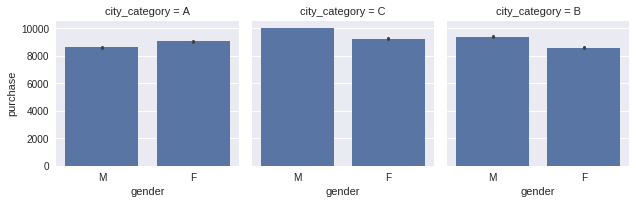

In [40]:
# https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
purchase_city = sns.FacetGrid(df2,col="city_category")
purchase_city.map(sns.barplot, "gender", "purchase");
plt.show()

Clearly people from City_Category C are showing higher purchase capacity as compared to the other two cities on average.
For City_categories B and C, Males tend to dominate the purchasing, whereas it is the opposite for City Category_C, where Females tend to puchase more than men. It is a useful insight, and it be useful to oserve which age group of females does higher purchasing.

### Linear Regression

In [41]:
# Dropping unnecessary columns in the data
df=df.drop('product_id')
df=df.drop('user_id')
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- city_category: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- marital_status: long (nullable = true)
 |-- occupation: long (nullable = true)
 |-- product_category_1: long (nullable = true)
 |-- product_category_2: float (nullable = false)
 |-- product_category_3: float (nullable = false)
 |-- purchase: long (nullable = true)
 |-- stay_in_current_city_years: string (nullable = true)



In [42]:
# Getting Numerical Columns from the Spark Dataframe
num_cols=['marital_status','occupation','product_category_1','product_category_2','product_category_3','purchase']

In [43]:
#Generating a list of Categorical columns
categoricalcols=[]
for col in df.columns:
    if col in num_cols:
        pass
    else:
        categoricalcols.append(col)

In [44]:
categoricalcols

['age', 'city_category', 'gender', 'stay_in_current_city_years']

### ENCODING - Converting categorical columns to numeric

In [45]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer

In [46]:
# Converting categorical columns to numeric using string indexer
flag=0
for col in categoricalcols:
    if flag != 1:
        indexer = StringIndexer(inputCol=col, outputCol=col+"_categorical").fit(df)
        indexed_df = indexer.transform(df)
        flag=1
    else:
        indexer = StringIndexer(inputCol=col, outputCol=col+"_categorical").fit(indexed_df)
        indexed_df = indexer.transform(indexed_df)

In [47]:
indexed_df.toPandas()

,age,city_category,gender,marital_status,occupation,product_category_1,product_category_2,product_category_3,purchase,stay_in_current_city_years,age_categorical,city_category_categorical,gender_categorical,stay_in_current_city_years_categorical
0,0-17,A,F,0,10,3,0.0,0.0,8370,2,6.0,2.0,1.0,1.0
1,0-17,A,F,0,10,1,6.0,14.0,15200,2,6.0,2.0,1.0,1.0
2,0-17,A,F,0,10,12,0.0,0.0,1422,2,6.0,2.0,1.0,1.0
3,0-17,A,F,0,10,12,14.0,0.0,1057,2,6.0,2.0,1.0,1.0
4,55+,C,M,0,16,8,0.0,0.0,7969,4+,5.0,1.0,0.0,3.0
5,26-35,A,M,0,15,1,2.0,0.0,15227,3,0.0,2.0,0.0,2.0
6,46-50,B,M,1,7,1,8.0,17.0,19215,2,3.0,0.0,0.0,1.0
7,46-50,B,M,1,7,1,15.0,0.0,15854,2,3.0,0.0,0.0,1.0
8,46-50,B,M,1,7,1,16.0,0.0,15686,2,3.0,0.0,0.0,1.0
9,26-35,A,M,1,20,8,0.0,0.0,7871,1,0.0,2.0,0.0,0.0


In [48]:
# Lets see how age categiry is mapped to integer values
indexed_df.select('age','age_categorical').show(15)

+-----+---------------+
|  age|age_categorical|
+-----+---------------+
| 0-17|            6.0|
| 0-17|            6.0|
| 0-17|            6.0|
| 0-17|            6.0|
|  55+|            5.0|
|26-35|            0.0|
|46-50|            3.0|
|46-50|            3.0|
|46-50|            3.0|
|26-35|            0.0|
|26-35|            0.0|
|26-35|            0.0|
|26-35|            0.0|
|26-35|            0.0|
|51-55|            4.0|
+-----+---------------+
only showing top 15 rows



In [49]:
indexed_df.printSchema()

root
 |-- age: string (nullable = true)
 |-- city_category: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- marital_status: long (nullable = true)
 |-- occupation: long (nullable = true)
 |-- product_category_1: long (nullable = true)
 |-- product_category_2: float (nullable = false)
 |-- product_category_3: float (nullable = false)
 |-- purchase: long (nullable = true)
 |-- stay_in_current_city_years: string (nullable = true)
 |-- age_categorical: double (nullable = false)
 |-- city_category_categorical: double (nullable = false)
 |-- gender_categorical: double (nullable = false)
 |-- stay_in_current_city_years_categorical: double (nullable = false)



In [50]:
#Getting total number of string columns
strcols=[]
for i in range(0,len(indexed_df.columns)):
    if (indexed_df.dtypes[i][1]=='string'):
        strcols.append(indexed_df.dtypes[i][0])

In [51]:
len(strcols)

4

In [52]:
indexed_df.select(strcols)

DataFrame[age: string, city_category: string, gender: string, stay_in_current_city_years: string]

In [53]:
# Drop all the string columns which are converted to ca
for i in strcols:
    indexed_df= indexed_df.drop(i)

In [54]:
# To verify that the indexed_df data frame has all numeric values
indexed_df.printSchema()

root
 |-- marital_status: long (nullable = true)
 |-- occupation: long (nullable = true)
 |-- product_category_1: long (nullable = true)
 |-- product_category_2: float (nullable = false)
 |-- product_category_3: float (nullable = false)
 |-- purchase: long (nullable = true)
 |-- age_categorical: double (nullable = false)
 |-- city_category_categorical: double (nullable = false)
 |-- gender_categorical: double (nullable = false)
 |-- stay_in_current_city_years_categorical: double (nullable = false)



In [55]:
# Common statistics of all the columns
indexed_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
marital_status,537577,0.4087972513705013,0.49161215222967514,0,1
occupation,537577,8.082710011775058,6.524119769935539,0,20
product_category_1,537577,5.295546498455105,3.7507009498798096,1,18
product_category_2,537577,6.784907092379324,6.21161846455343,0.0,18.0
product_category_3,537577,3.871772787898292,6.265963443383427,0.0,18.0
purchase,537577,9333.859852635065,4981.022132656451,185,23961
age_categorical,537577,1.450162488350506,1.62650944151932,0.0,6.0
city_category_categorical,537577,0.8477334409768275,0.816819144371732,0.0,2.0
gender_categorical,537577,0.2459126785558162,0.4306274236930542,0.0,1.0


### Building the model

In [56]:
# Dropping purchase (target dependent variable)
model_df = indexed_df.drop('purchase')

In [57]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Preparing a list of all the input columns
reg=[]
for col in indexed_df.columns:
    if col=='purchase':
        continue
    else:
        reg.append(col)
        
vectorAssembler = VectorAssembler(inputCols = reg, outputCol = 'Features')
bfriday_df = vectorAssembler.transform(indexed_df)

In [58]:
type(bfriday_df)

pyspark.sql.dataframe.DataFrame

In [59]:
bfriday_df.select(['Features','purchase']).toPandas()

,Features,purchase
0,"[0.0, 10.0, 3.0, 0.0, 0.0, 6.0, 2.0, 1.0, 1.0]",8370
1,"[0.0, 10.0, 1.0, 6.0, 14.0, 6.0, 2.0, 1.0, 1.0]",15200
2,"[0.0, 10.0, 12.0, 0.0, 0.0, 6.0, 2.0, 1.0, 1.0]",1422
3,"[0.0, 10.0, 12.0, 14.0, 0.0, 6.0, 2.0, 1.0, 1.0]",1057
4,"[0.0, 16.0, 8.0, 0.0, 0.0, 5.0, 1.0, 0.0, 3.0]",7969
5,"[0.0, 15.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0]",15227
6,"[1.0, 7.0, 1.0, 8.0, 17.0, 3.0, 0.0, 0.0, 1.0]",19215
7,"[1.0, 7.0, 1.0, 15.0, 0.0, 3.0, 0.0, 0.0, 1.0]",15854
8,"[1.0, 7.0, 1.0, 16.0, 0.0, 3.0, 0.0, 0.0, 1.0]",15686
9,"(1.0, 20.0, 8.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0)",7871


In [60]:
# Preparing train and test data set
splits = bfriday_df.randomSplit([0.8, 0.2],seed='2019')
train_df = splits[0]
test_df = splits[1]

In [61]:
# Create a Linear Regression Model object
linearReg = LinearRegression(featuresCol = 'Features', labelCol='purchase', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [62]:
# Fit the model to the data and call this model lrModel
lr_model = linearReg.fit(train_df)

In [63]:
print("Coefficients: " + str(lr_model.coefficients))

Coefficients: [44.7400771573,9.46128471439,-318.985636974,9.65183461725,148.566171474,27.6348835321,-32.820223467,-478.158013881,-8.3515874888]


In [64]:
print("Intercept: " + str(lr_model.intercept))

Intercept: 10404.4318092


In [65]:
lr_predictions=lr_model.transform(test_df)
lr_predictions.select(['prediction','Features','purchase']).toPandas()

,prediction,Features,purchase
0,10019.805725,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0)",4010
1,10035.922774,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0)",4276
2,10066.723905,"(0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0, 1.0)",4340
3,10003.102550,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0)",4446
4,10041.669142,"(0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0, 4.0)",7635
5,10195.985706,"(0.0, 0.0, 1.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0)",7727
6,10195.985706,"(0.0, 0.0, 1.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0)",7821
7,10077.094585,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)",7844
8,10085.446172,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",7969
9,9773.097460,"(0.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0.0, 1.0, 0.0)",7973


In [66]:
lr_predictions.registerTempTable('pred_table')
sqlContext.sql('select prediction, occupation, purchase from pred_table where occupation = 0').show(10)

+------------------+----------+--------+
|        prediction|occupation|purchase|
+------------------+----------+--------+
|10019.805725278557|         0|    4010|
| 10035.92277376795|         0|    4276|
|10066.723904853918|         0|    4340|
|10003.102550300948|         0|    4446|
|10041.669142387504|         0|    7635|
| 10195.98570634089|         0|    7727|
| 10195.98570634089|         0|    7821|
|10077.094584723756|         0|    7844|
| 10085.44617221256|         0|    7969|
| 9773.097459524091|         0|    7973|
+------------------+----------+--------+
only showing top 10 rows



In [67]:
#Evaluating R squared on test data for the Mean Model.
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="purchase",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.130943


### Regularization

In [68]:
#Creating a Correlation Dictionary to select the best positively and negatively Correlated values.
correlation_dict={}

for col in indexed_df.columns:
    correlation_dict[col]=indexed_df.corr(col1='purchase',col2=col)

In [69]:
#https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
import operator
sorted_dict = sorted(correlation_dict.items(), key=operator.itemgetter(1),reverse=True)

In [70]:
sorted_dict[0:15][0][0]

'purchase'

In [71]:
sorted_dict[-5:]

[('marital_status', 0.00012901814909541888),
 ('stay_in_current_city_years_categorical', -0.0032702991465657183),
 ('city_category_categorical', -0.010854036609876973),
 ('gender_categorical', -0.0600861659869464),
 ('product_category_1', -0.3141247354708834)]

In [72]:
# Creating new_col_list which joins the slices created above.
new_col_list=sorted_dict[0:15]+sorted_dict[-5:]

In [73]:
collist=[]
for item in new_col_list:
    if item[0]=='purchase':
        continue
    else:
        collist.append(item[0])

In [74]:
# Getting Correlation within the columns of collist. 
f=indexed_df.select(collist).toPandas().corr()

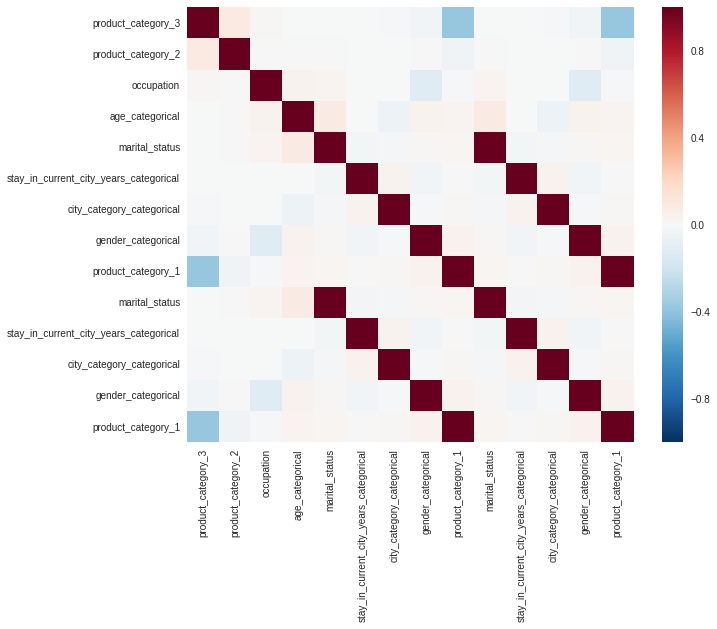

In [75]:
#Creating heatmap for visualizing the correlated columns so that we can eliminate auto-correlation.

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(data=f)
plt.show()

In [76]:
# Let's improve the fit by removing the variables which are highly correlated and do the linear regression again
new_indexed_df=indexed_df.drop('age_categorical')
new_indexed_df=new_indexed_df.drop('product_category_2')
#Running the Feature selected model and checking for R squared Value.

reg=[]
for col in new_indexed_df.columns:
    if col=='purchase':
        continue
    else:
        reg.append(col)

vectorAssembler = VectorAssembler(inputCols = reg, outputCol = 'Features')
bfriday_df = vectorAssembler.transform(indexed_df)

splits = bfriday_df.randomSplit([0.8, 0.2],seed='2019')
train_df = splits[0]
test_df = splits[1]

linearReg = LinearRegression(featuresCol = 'Features', labelCol='purchase', maxIter=10, regParam=0.3, elasticNetParam=0.8)

lr_model = linearReg.fit(train_df)

lr_predictions=lr_model.transform(test_df)
lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="purchase",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.130744


We don't get a significant difference in the r squared value.